### Import all required python libraries

In [1]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE

%matplotlib inline

### Read the input data and split into train and test set

In [2]:
df_train = pd.read_csv('../input/train.csv', nrows=2000) #https://www.kaggle.com/competitions/digit-recognizer
train, test = train_test_split(df_train, test_size=0.2, random_state=0)

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600 entries, 582 to 684
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 9.6 MB


In [4]:
train.shape

(1600, 785)

In [5]:
train.head(2)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
582,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
159,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
#Splitting the data into features and target
train_X = train[train.columns[1:]]
train_y = train['label']

test_X = test[test.columns[1:]]
test_y = test['label']

### Visualization and Classification by Dimensionality Reduction 

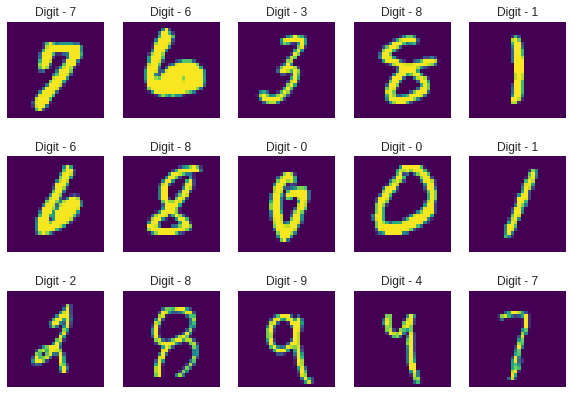

In [7]:
#Lets check the first 15 images

fig, ax = plt.subplots(3,5, figsize=(10,7), subplot_kw={'xticks':(), 'yticks': ()})
ax = ax.ravel()
for i in range(15):
    pixels = train_X.iloc[i].values.reshape(-1,28)
    ax[i].imshow(pixels, cmap='viridis')
    ax[i].set_title("Digit - " + str(train_y.iloc[i]))

In [8]:
#We can scale the grayscale value to be between 0 and 1 for better stability

train_X_scaled = train_X/255
test_X_scaled = test_X/255

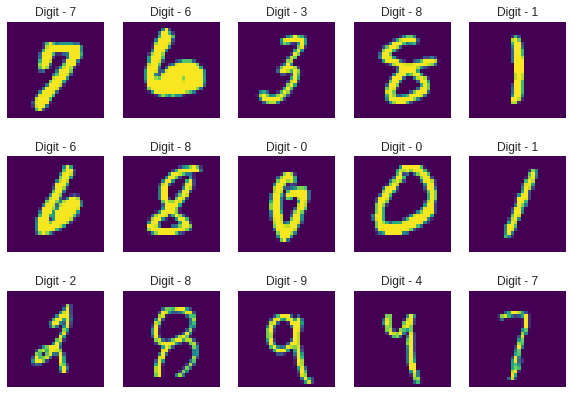

In [9]:
#Lets plot again to see if scaling affected the actual images

fig, ax = plt.subplots(3,5, figsize=(10,7), subplot_kw={'xticks':(), 'yticks': ()})
ax = ax.ravel()
for i in range(15):
    pixels = train_X_scaled.iloc[i].values.reshape(-1,28)
    ax[i].imshow(pixels, cmap='viridis')
    ax[i].set_title("Digit - " + str(train_y.iloc[i]))

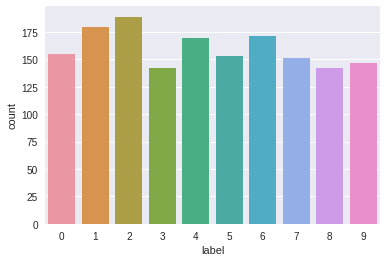

In [10]:
#Lets check the input data to see if it is skewed. If it is skewed it will affect the feature extraction
#But we can see data is almost uniformly distributed
sns.countplot(train_y)

###Principal Component Analysis (PCA)

In [11]:
#Reducing dimension into 2 components
pca = PCA(n_components=2, random_state=0, whiten=True)
pca.fit(train_X_scaled)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=0,
  svd_solver='auto', tol=0.0, whiten=True)

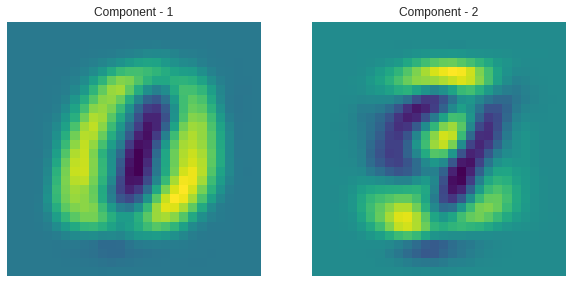

In [12]:
#Lets see the components from PCA
fig, ax = plt.subplots(1,2, figsize=(10,6), subplot_kw={'xticks':(), 'yticks': ()})
ax = ax.ravel()
for i in range(2):
    pixels = pca.components_[i].reshape(-1,28)
    ax[i].imshow(pixels, cmap='viridis')
    ax[i].set_title("Component - " + str(i+1))

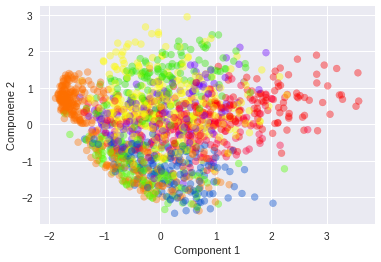

In [13]:
#transform the train and test data using the above 2 components
train_X_pca = pca.transform(train_X_scaled)
test_X_pca = pca.transform(test_X_scaled)

#plot the components
plt.scatter(train_X_pca[:,0], train_X_pca[:,1], c=train_y.values,  cmap='prism', alpha=0.4)
plt.xlabel('Component 1')
plt.ylabel('Componene 2')

####As we can see PCA did not do a good job in classification with 2 components, most of the data points are overlapping each other.

In [14]:
#Classification by KNN- As we expect the score would be very low
knn_pca = KNeighborsClassifier(n_neighbors=4, n_jobs=8)
knn_pca.fit(train_X_pca, train_y)
print("Train score {} ".format(knn_pca.score(train_X_pca, train_y)))
print("Test score {} ".format(knn_pca.score(test_X_pca, test_y)))

Train score 0.6025 
Test score 0.3875 


In [15]:
#From the below explained variance we can see that 2 components are not enough to capture all varience in data
pca.explained_variance_ratio_

array([ 0.09849813,  0.07436017])

In [16]:
#Lets check how many principal componenets will be required to capture maximum varience
pca = PCA(random_state=0, whiten=True)
pca.fit(train_X_scaled)

#Cumulative sum of varience ratio of all components
exp_var_cum=np.cumsum(pca.explained_variance_ratio_)

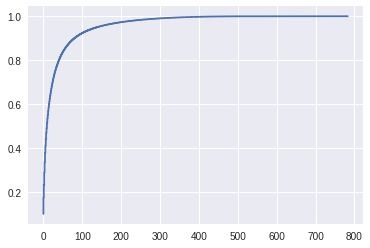

In [17]:
plt.step(range(exp_var_cum.size), exp_var_cum)

####From the above plot it is obvious that we need at least 50 components to capture maximum variance.

In [18]:
# 25 components are enough to capture 70% varience
exp_var_cum[25]

0.70675122327621365

In [19]:
#Lets try with 25 PCA Components.

pca = PCA(n_components=25, random_state=0, whiten=True)
pca.fit(train_X_scaled)
train_X_pca = pca.transform(train_X_scaled)
test_X_pca = pca.transform(test_X_scaled)

knn_pca = KNeighborsClassifier(n_neighbors=3, n_jobs=8)
knn_pca.fit(train_X_pca, train_y)
print("Train score {} ".format(knn_pca.score(train_X_pca, train_y)))
print("Test score {} ".format(knn_pca.score(test_X_pca, test_y)))

Train score 0.9475 
Test score 0.88 


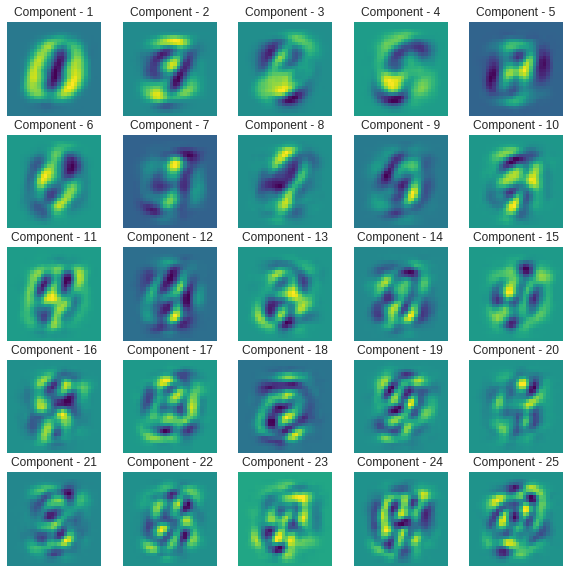

In [20]:
#Lets see all 25 PCA Componenets we used for the model
fig, ax = plt.subplots(5,5, figsize=(10,10), subplot_kw={'xticks':(), 'yticks': ()})
ax = ax.ravel()
for i in range(25):
    pixels = pca.components_[i].reshape(-1,28)
    ax[i].imshow(pixels, cmap='viridis')
    ax[i].set_title("Component - " + str(i+1))

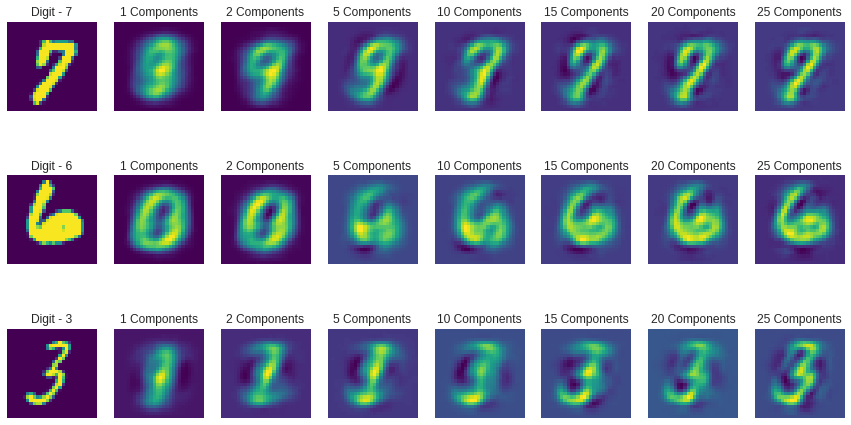

In [21]:
#Lets reconstruct the images using different number of PCA Components
fig, ax = plt.subplots(3,8, figsize=(15,8), subplot_kw={'xticks':(), 'yticks': ()})
components=[1,2,5,10,15,20,25]
for i in range(3):
    for j in range(8):
        if j == 0:
            pixels = train_X_scaled.iloc[i].values.reshape(-1,28)
            ax[i][j].imshow(pixels, cmap='viridis')
            ax[i][j].set_title("Digit - " + str(train_y.iloc[i]))
        else:
            pca = PCA(n_components=components[j-1], random_state=0, whiten=True)
            pca.fit(train_X_scaled)
            train_X_pca = pca.transform(train_X_scaled)
            train_X_pca_back = pca.inverse_transform(train_X_pca)
        
            pixels = train_X_pca_back[i].reshape(-1,28)
            ax[i][j].imshow(pixels, cmap='viridis')
            ax[i][j].set_title(str(components[j-1]) + " Components")

#### We were able to reconstruct a  decent image using 25 principal components

### Non-Negative Matrix Factorization (NMF)

In [22]:
nmf = NMF(n_components=2, random_state=0)
nmf.fit(train_X_scaled)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=2, random_state=0, shuffle=False, solver='cd', tol=0.0001,
  verbose=0)

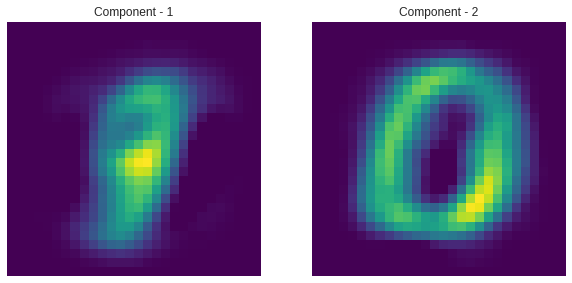

In [23]:
#Lets see the components from NMF
fig, ax = plt.subplots(1,2, figsize=(10,6), subplot_kw={'xticks':(), 'yticks': ()})
ax = ax.ravel()
for i in range(2):
    pixels = nmf.components_[i].reshape(-1,28)
    ax[i].imshow(pixels, cmap='viridis')
    ax[i].set_title("Component - " + str(i+1))

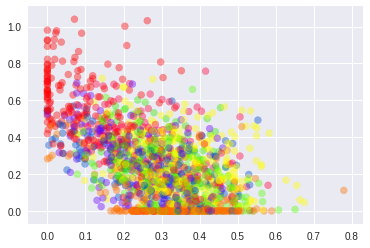

In [24]:
train_X_nmf = nmf.transform(train_X_scaled)
test_X_nmf = nmf.transform(test_X_scaled)

plt.scatter(train_X_nmf[:,0], train_X_nmf[:,1], c=train_y.values,  cmap='prism', alpha=0.4)

####As we can see, with 2 components, NMF did not do a good job either.

In [25]:
#Classification by KNN
knn_nmf = KNeighborsClassifier(n_neighbors=5, n_jobs=8)
knn_nmf.fit(train_X_nmf, train_y)
print("Train score {} ".format(knn_nmf.score(train_X_nmf, train_y)))
print("Test score {} ".format(knn_nmf.score(test_X_nmf, test_y)))

Train score 0.471875 
Test score 0.3 


In [26]:
#With nore NMF components
nmf = NMF(n_components=30, random_state=0)
nmf.fit(train_X_scaled)
train_X_nmf = nmf.transform(train_X_scaled)
test_X_nmf = nmf.transform(test_X_scaled)

knn_nmf = KNeighborsClassifier(n_neighbors=4, n_jobs=8)
knn_nmf.fit(train_X_nmf, train_y)
print("Train score {} ".format(knn_nmf.score(train_X_nmf, train_y)))
print("Test score {} ".format(knn_nmf.score(test_X_nmf, test_y)))

Train score 0.92375 
Test score 0.86 


### t-SNE Manifold Learning

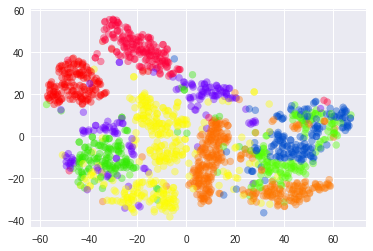

In [27]:
tsne = TSNE(n_components=2, random_state=0)
train_X_tsne = tsne.fit_transform(train_X_scaled, train_y)

plt.scatter(train_X_tsne[:,0], train_X_tsne[:,1], c=train_y.values,  cmap='prism', alpha=0.4)

#### t-SNE does a good job in separating data points with 2 components. We cannot use this for transforming new data, means it is not useful for classifying a different set of data 